In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import random
from torch import nn, optim
import torch.nn.functional as F
import time
# import cvxpy as cp
import pickle
import scipy


In [2]:
class DynSystem():
    def __init__(self, Matrix_A, Matrix_B, Matrix_C, dim_state, dim_action, dim_observe, Penalty_action):
  
        self.Matrix_A = torch.tensor(Matrix_A, dtype=torch.float32)
        self.Matrix_B = torch.tensor(Matrix_B, dtype=torch.float32)
        self.Matrix_C = torch.tensor(Matrix_C, dtype=torch.float32)
     
        self.sigma_e = 0.5
        self.dim_action = dim_action
        self.dim_state = dim_state
        self.dim_observe = dim_observe
        self.state = None 
        self.delta_t = 1
        self.Penalty_action = torch.tensor(Penalty_action, dtype=torch.float32)
        
    def step(self, action):
  
        self.state = torch.matmul(self.state, self.Matrix_A.T) + torch.matmul(action, self.Matrix_B.T)
        return self.state
    
    def set_state(self, state_input):
    
        self.state = torch.tensor(state_input, dtype=torch.float32)

    def reset(self):
    
        self.state = torch.rand((1, self.dim_action)) * 2 - 1  
        return self.state


In [3]:
Matrix_A = torch.tensor([[1.178, 0.001, 0.511, -0.403],
                         [-0.051, 0.661, -0.011, 0.061],
                         [0.076, 0.335, 0.560, 0.382],
                         [0, 0.335, 0.089, 0.849]], dtype=torch.float32)

Matrix_B = torch.tensor([[0.004, -0.087],
                         [0.467, 0.001],
                         [0.213, -0.235],
                         [0.213, -0.016]], dtype=torch.float32)


In [4]:
dim_state =  Matrix_A.shape[0]
dim_action =  Matrix_B.shape[1]
dim_observe =  4
Matrix_C = torch.eye(4, dtype=torch.float32) 
Penalty_action = 0.1

env = DynSystem(Matrix_A, Matrix_B, Matrix_C, dim_state, dim_action, dim_observe, Penalty_action)


C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/1944148939.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_A = torch.tensor(Matrix_A, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/1944148939.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_B = torch.tensor(Matrix_B, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/1944148939.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_C = torch.tensor(Matrix_C, dtype=torch.float32)


In [5]:
def Action_linear(state, linear_coff, env):
   
    state = torch.tensor(state, dtype=torch.float32)

  
    linear_coff = torch.tensor(linear_coff, dtype=torch.float32)

    action_nonconstrain = torch.matmul(state, linear_coff.T)  

    return action_nonconstrain

In [6]:
linear_coff = torch.tensor([[0.7610, -1.1363, 1.6945, -1.8123],
                            [3.5351, 0.4827, 3.3014, -2.6215]], dtype=torch.float32)

action_units = dim_action  


In [7]:
linear_coff0 = torch.tensor([[0.0639, -0.7069, -0.1572, -0.6710],
                             [2.1481, 0.0875, 1.4899, -0.9805]], dtype=torch.float32)


C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/1944148939.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.state = torch.tensor(state_input, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/957829648.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/957829648.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  linear_coff = torch.tensor(linear_coff, dtype=torch.float32)


Initial state: tensor([[-0.0235,  0.0081, -0.0917, -0.0503]])


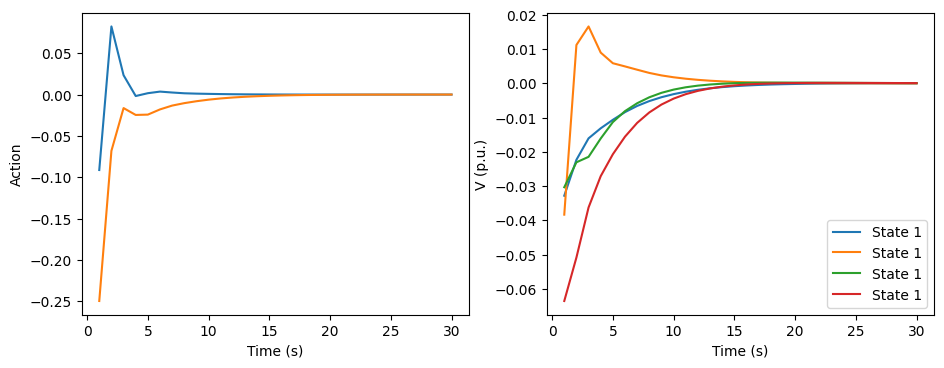

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np


Trajectory_Linear = []

# Initialize the state
init_state = np.random.uniform(-0.1, 0.1, (1, dim_state)) 
s = torch.tensor(init_state, dtype=torch.float32)  
env.set_state(s)

SimulationLength = 30  
Record_u_Linear = []   
Record_q_Linear = []   
Record_Loss_Linear = []  
Loss_Linear = 0  
print('Initial state:', s)

for i in range(SimulationLength):
    u = torch.squeeze(Action_linear(s, linear_coff, env)) 
    next_s = torch.matmul(s, Matrix_A.T) + torch.matmul(u, Matrix_B.T)  
    
    s = next_s.clone()  
    
    Trajectory_Linear.append(s.cpu().detach().numpy())  
    Record_u_Linear.append(u.cpu().detach().numpy())  


Trajectory_Linear = np.array(Trajectory_Linear)  
Record_u_Linear = np.array(Record_u_Linear)

plt.figure(figsize=(11, 4), dpi=100)

TimeRecord = np.arange(1, SimulationLength + 1)
TimeRecord = env.delta_t * TimeRecord  
plt.subplot(1, 2, 1)
plt.plot(TimeRecord, Record_u_Linear)
plt.xlabel('Time (s)')
plt.ylabel('Action')

plt.subplot(1, 2, 2)


for i in range(Trajectory_Linear.shape[1]):  
    plt.plot(TimeRecord, Trajectory_Linear[:, i], label=f'State {i+1}')

plt.xlabel('Time (s)')
plt.ylabel('V (p.u.)')
plt.legend()

plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Linear(nn.Module):
    def __init__(self, units, action_units, env, batchsize):
        super(Linear, self).__init__()
        
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units
        self.dim_state = env.dim_state
        self.dim_action = env.dim_action
        self.dim_observe = env.dim_observe
        self.batchsize = batchsize

        self.k_node_p = nn.Parameter(torch.randn(self.dim_action, self.dim_observe) * 0.1) 

    def forward(self, prev_state):

        action_nonconstrain0_node_p = torch.matmul(prev_state, self.k_node_p.T)
        return action_nonconstrain0_node_p


In [10]:
import torch
import time
import numpy as np
from torch.distributions import MultivariateNormal

class PolicyGradient(nn.Module):
    def __init__(self, units, action_units, env, mu, batchsize, batchsize_test, **kwargs):
        super(PolicyGradient, self).__init__()

        self.mu = mu 
        self.sigma_e = env.sigma_e
        self.units = units
        self.state_size = units
        self.action_units_node_p = action_units
        self.action_units_node_i = action_units    
        self.batchsize = batchsize
        self.batchsize_test = batchsize_test
        self.Matrix_A = torch.tensor(env.Matrix_A, dtype=torch.float32)
        self.Matrix_B = torch.tensor(env.Matrix_B, dtype=torch.float32)
        self.Matrix_C = torch.tensor(env.Matrix_C, dtype=torch.float32)
        
        # Initialize optimizer here
        self.optimizer = torch.optim.Adam(mu.parameters(), lr=0.05)

    def Sample(self, T, initial_state, Noise_batch):
        Batch_num = self.batchsize
        prev_state = torch.tensor(initial_state, dtype=torch.float32)
        reward_record = torch.zeros(Batch_num)
        Trajectory_record = []
        Action_record = []
        
        for i in range(T):
            observance = torch.matmul(prev_state, self.Matrix_C.T)
            Trajectory_record.append(observance)
            
            # Pass mu as a parameter here
            observe_action = ChooseAction_OuterNoise(observance, self.mu, Noise_batch[i])
            Action_record.append(observe_action)
            
            reward_record += (env.Penalty_action * torch.sum(torch.abs(observe_action), dim=1) +
                              torch.sum(torch.abs(observance), dim=1))
            
  
            new_state = torch.matmul(prev_state, self.Matrix_A.T) + torch.matmul(observe_action, self.Matrix_B.T)
            prev_state = new_state

        return Trajectory_record, Action_record, reward_record

    def Sample_One(self, T, initial_state, Noise_batch):
        Batch_num = self.batchsize
        prev_state = torch.tensor(initial_state, dtype=torch.float32)
        observance = torch.matmul(prev_state, self.Matrix_C.T)
        
        reward_record = torch.zeros(Batch_num)
        Trajectory_record = []
        Action_record = []
        
        for i in range(T):
            Trajectory_record.append(observance)
            action = self.mu(observance) + Noise_batch[i]  # Use the mu passed as an argument
            Action_record.append(action)
            
            reward_record += (env.Penalty_action * torch.sum(torch.abs(action), dim=1) +
                              torch.sum(torch.abs(prev_state), dim=1))
            
            # Integrate the state transition dynamics
            new_state = prev_state - torch.matmul(action, self.Matrix_X.T)
            prev_state = new_state

        return Trajectory_record, Action_record, reward_record

    def Test(self, T, initial_state, Noise_batch):
        Batch_num = self.batchsize_test
        prev_state = torch.tensor(initial_state, dtype=torch.float32)
        reward_record = torch.zeros(Batch_num)
        Trajectory_record = []
        Action_record = []
        
        for i in range(T):
            observance = torch.matmul(prev_state, self.Matrix_C.T)
            Trajectory_record.append(observance)
            
            # Pass mu as a parameter here
            observe_action = ChooseAction_OuterNoise(observance, self.mu, Noise_batch[i])
            Action_record.append(observe_action)
            
            reward_record += (env.Penalty_action * torch.sum(torch.abs(observe_action), dim=1) +
                              torch.sum(torch.abs(observance), dim=1))
            
            new_state = torch.matmul(prev_state, self.Matrix_A.T) + torch.matmul(observe_action, self.Matrix_B.T)
            prev_state = new_state

        return Trajectory_record, Action_record, reward_record

    def Train(self, Trajectory_record, Action_record, reward_record):
        reward_record = reward_record - torch.mean(reward_record)
        
  
        self.optimizer.zero_grad()
        
        sum_log_prob = torch.zeros(self.batchsize, dtype=torch.float32)
        
        for i in range(len(Trajectory_record)):
            mu_batch = self.mu(Trajectory_record[i])
            
            if mu_batch.shape != Action_record[i].shape:
                print(f"Shape mismatch: mu_batch.shape = {mu_batch.shape}, Action_record[i].shape = {Action_record[i].shape}")
                continue  

            dist = MultivariateNormal(mu_batch, torch.diag(self.sigma_e * torch.ones(mu_batch.shape[1])))
            

            log_prob = dist.log_prob(Action_record[i])
            
            sum_log_prob += log_prob
        
        loss = torch.mean(sum_log_prob * reward_record)
        
        loss.backward()

        self.optimizer.step()
        
        return loss


def ChooseAction_OuterNoise(s, mu, noise):
   
    mu_e = mu(s)  
    
    action_nonconstrain = mu_e + noise
    
    return torch.squeeze(action_nonconstrain)


In [11]:

Init_state_bound = 0.1
PredictLength = 20
Batch_num_test = 800
T = 30  
initial_state_test = np.random.uniform(-Init_state_bound, Init_state_bound, (Batch_num_test, dim_state))
test_sigma = 0.001

Noise_batch_test = []
for t in range(T):
    normal_dist = torch.normal(mean=torch.zeros((Batch_num_test, dim_action)), 
                               std=test_sigma * torch.ones((Batch_num_test, dim_action)))
    Noise_batch_test.append(normal_dist)


In [ ]:

PI_mono_list = []
loss_list = []
loss_list_test = []
computer_time_list = []
loop_seed = 1

# Hyperparameters
episodes = 400  
action_units = dim_action
units = action_units  
internal_units = 20  
Init_state_bound = 0.1
T = 30  
Batch_num = 1000 
PrintUpdate = 1
Batch_num_test = 800
num_gen_step = 3
learning_rate_initial = 0.05
decay_stage = 50
decay_rate = 0.5

for loop in range(loop_seed):
    start = time.time()

    mu = Linear(units, dim_observe, env, Batch_num)
    mu.k_node_p.data = 0.6 * linear_coff0  
    Policy_gradient_class = PolicyGradient(units, dim_observe, env, mu, Batch_num, Batch_num_test)

    print(mu.k_node_p.data)

    Loss_record = []
    Loss_record_test = []
    Loss_record_test_std = []
    Pe_rnn_record = []

    optimizer = torch.optim.Adam(mu.parameters(), lr=learning_rate_initial)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

    Trajectory_record, Action_record, reward_record = Policy_gradient_class.Test(T, initial_state_test, Noise_batch_test)
    
    reward_record_np = reward_record.cpu().detach().numpy() if isinstance(reward_record, torch.Tensor) else reward_record
    
    Loss_record_test.append(np.mean(reward_record_np))
    Loss_record_test_std.append(np.std(reward_record_np)) 
    for i in range(episodes):
        # Decay the noise over time
        Policy_gradient_class.sigma_e = 0.005 * np.exp(-i / 100)

        # Generate initial states for the batch
        initial_state = np.random.uniform(-Init_state_bound, Init_state_bound, (Batch_num, dim_state))

        # Generate noise for each batch
        Noise_batch = []
        for t in range(T):
            normal_dist = torch.normal(mean=torch.zeros((Batch_num, dim_action)),
                                       std=Policy_gradient_class.sigma_e * torch.ones((Batch_num, dim_action)))
            Noise_batch.append(normal_dist)

        # Sample trajectories and calculate reward
        Trajectory_record, Action_record, reward_record = Policy_gradient_class.Sample(T, initial_state, Noise_batch)
        loss = Policy_gradient_class.Train(Trajectory_record, Action_record, reward_record)
        Loss_record.append(torch.mean(reward_record).item())  # Averaging the rewards


        if i % PrintUpdate == 0:
            print(f"Episode {i}, Batch loss: {Loss_record[-1]}")

   
        Trajectory_record, Action_record, reward_record = Policy_gradient_class.Test(T, initial_state_test, Noise_batch_test)
        
        reward_record_np = reward_record.cpu().detach().numpy() if isinstance(reward_record, torch.Tensor) else reward_record
        
        
        Loss_record_test.append(np.mean(reward_record_np))
        Loss_record_test_std.append(np.std(reward_record_np)) 

      
        if i % PrintUpdate == 0:
            print(f"Batch loss test: {Loss_record_test[-1]}")

    end = time.time()
    print(f"Time taken for this loop: {end - start} seconds")
    computer_time_list.append(end - start)
    loss_list.append(np.array(Loss_record))

C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2648353442.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_A = torch.tensor(env.Matrix_A, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2648353442.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_B = torch.tensor(env.Matrix_B, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2648353442.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_C = torch.tensor(env.Matrix_C, dtype=torch.float32)


tensor([[ 0.0383, -0.4241, -0.0943, -0.4026],
        [ 1.2889,  0.0525,  0.8939, -0.5883]])
Episode 0, Batch loss: 1.8763906955718994
Batch loss test: 2.380213499069214
Episode 1, Batch loss: 2.3998324871063232
Batch loss test: 2.195297956466675
Episode 2, Batch loss: 2.1863787174224854
Batch loss test: 2.3355095386505127
Episode 3, Batch loss: 2.3541007041931152
Batch loss test: 2.2743303775787354
Episode 4, Batch loss: 2.3049073219299316
Batch loss test: 2.192636728286743
Episode 5, Batch loss: 2.1491377353668213
Batch loss test: 2.1827034950256348
Episode 6, Batch loss: 2.231515884399414
Batch loss test: 2.179976463317871
Episode 7, Batch loss: 2.2003226280212402
Batch loss test: 2.0161828994750977
Episode 8, Batch loss: 2.0483624935150146
Batch loss test: 1.8787564039230347
Episode 9, Batch loss: 1.918960690498352
Batch loss test: 1.8130426406860352
Episode 10, Batch loss: 1.8333024978637695
Batch loss test: 1.7271485328674316
Episode 11, Batch loss: 1.8272701501846313
Batch loss 

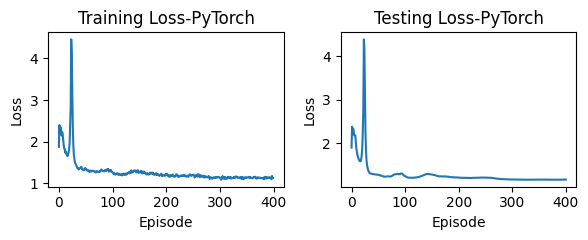

In [ ]:
import matplotlib.pyplot as plt
import torch

Loss_record_np = Loss_record.cpu().detach().numpy() if isinstance(Loss_record, torch.Tensor) else Loss_record
Loss_record_test_np = Loss_record_test.cpu().detach().numpy() if isinstance(Loss_record_test, torch.Tensor) else Loss_record_test
fig = plt.figure(figsize=(6, 2.5), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(Loss_record_np)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss-PyTorch')

# Plot testing loss
plt.subplot(1, 2, 2)
plt.plot(Loss_record_test_np)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Testing Loss-PyTorch')

fig.tight_layout()

plt.show()


In [14]:
Loss_record_np[90]

1.3425991535186768

In [15]:
Loss_record_test_np[90]

1.2913985

In [16]:
PredictLength

20

C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/1944148939.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.state = torch.tensor(state_input, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/957829648.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/957829648.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  linear_coff = torch.tensor(linear_coff, dtype=torch.float32)


Initial state: tensor([[-0.0106, -0.0035, -0.0104, -0.0061]])


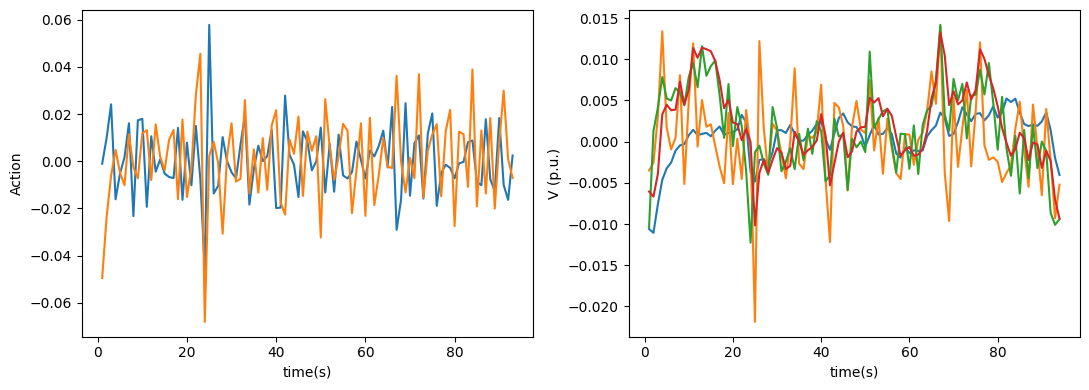

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Trajectory_Linear = [] 
Record_u_Linear = []
Record_q_Linear = []
Record_Loss_Linear = []
Q_init_ratio = 0.7
P_init_ratio = 0.7
PredictLength = 30 + 0
sigma_e = 0.01

init_state = torch.tensor(np.random.uniform(-0.02, 0.02, (1, dim_state)), dtype=torch.float32)
s = init_state.clone() 
env.set_state(s)

SimulationLength = dim_state + PredictLength * (dim_action + 1) - 1
Loss_Linear = 0

Trajectory_Linear.append(s @ Matrix_C.T)
print('Initial state:', s)

for i in range(SimulationLength):
    u = Action_linear(s, linear_coff, env) + torch.normal(torch.zeros((1, dim_action)), sigma_e * torch.ones((1, dim_action)))
    
    next_s = s @ Matrix_A.T + u @ Matrix_B.T
    s = next_s.clone()  
    Trajectory_Linear.append(s @ Matrix_C.T)
    Record_u_Linear.append(u.squeeze().detach().numpy())  

Trajectory_Linear = torch.stack(Trajectory_Linear).squeeze().detach().numpy()

plt.figure(figsize=(11, 4), dpi=100)
TimeRecord = np.arange(1, SimulationLength + 1)
TimeRecord = env.delta_t * TimeRecord

plt.subplot(1, 2, 1)
plt.plot(TimeRecord, Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')

TimeRecord = np.arange(1, SimulationLength + 2)
TimeRecord = env.delta_t * TimeRecord
plt.subplot(1, 2, 2)
plt.plot(TimeRecord, Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')

plt.tight_layout()
plt.show()


In [18]:
SimulationLength

93

In [53]:
import torch

Record_u_Linear = torch.tensor(Record_u_Linear, dtype=torch.float32)
Trajectory_Linear = torch.tensor(Trajectory_Linear, dtype=torch.float32)

HankelMatrix = torch.zeros((PredictLength * dim_action + PredictLength * dim_observe, SimulationLength - PredictLength + 1), dtype=torch.float32)

for i in range(SimulationLength - PredictLength + 1):
    HankelMatrix[0:PredictLength * dim_action, i] = Record_u_Linear[i:i + PredictLength].flatten()
    HankelMatrix[PredictLength * dim_action:PredictLength * dim_action + PredictLength * dim_observe, i] = \
        Trajectory_Linear[i:i + PredictLength].flatten()

HankelMatrix_u = HankelMatrix[0:PredictLength * dim_action, :]
HankelMatrix_x = HankelMatrix[PredictLength * dim_action:PredictLength * dim_action + PredictLength * dim_observe, :]

if torch.linalg.matrix_rank(HankelMatrix) == (dim_state + PredictLength * dim_action):
    print('rank condition holds')


rank condition holds


C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2979706673.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Record_u_Linear = torch.tensor(Record_u_Linear, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2979706673.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Trajectory_Linear = torch.tensor(Trajectory_Linear, dtype=torch.float32)


In [20]:
torch.linalg.matrix_rank(HankelMatrix)

tensor(64)

In [55]:
dim_action + PredictLength * dim_observe

122

In [21]:
dim_state + PredictLength * dim_action

64

In [59]:
HankelMatrix.shape

torch.Size([180, 64])

In [52]:
PredictLength

30

In [60]:
initial_state_test

array([[ 0.03787841,  0.02086007, -0.00048631, -0.09290051],
       [-0.0293741 ,  0.09447925,  0.00492017,  0.04599541],
       [-0.09919746, -0.01079182, -0.04489648, -0.03671215],
       ...,
       [-0.09746096,  0.0452987 ,  0.01524127,  0.02075494],
       [-0.04157579,  0.07649855, -0.05238851,  0.02053767],
       [-0.06557987, -0.0485172 , -0.06888025, -0.02638585]])

In [66]:
import torch
import time
import numpy as np
from scipy.linalg import block_diag

loop_seed = 1
PI_mono_list = []
loss_list = []
loss_list_test = []
computer_time_list = []
sigma_e_init = 0.005

Batch_num = 1000
learning_rate_initial = 0.01
decay_stage = 50
decay_rate = 0.5

for loop in range(loop_seed):
    start = time.time()

    mu = Linear(units, dim_action, env, Batch_num)
    mu.k_node_p.data =  0.6*linear_coff0  
    Policy_gradient_class = PolicyGradient(units, dim_action, env, mu, Batch_num, Batch_num_test)
    Loss_record = []
    Loss_record_test = []
    Loss_record_test_std = []
    Pe_rnn_record = []
    optimizer = torch.optim.Adam(mu.parameters(), lr=learning_rate_initial)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
    Policy_gradient_class.sigma_e = 0.3
    Trajectory_record, Action_record, reward_record = Policy_gradient_class.Test(T, initial_state_test, Noise_batch_test)

    reward_record_np = reward_record.cpu().detach().numpy() if isinstance(reward_record, torch.Tensor) else reward_record

    Loss_record_test.append(np.mean(reward_record_np))
    Loss_record_test_std.append(torch.std(reward_record).item())  

    for i in range(episodes):
        Policy_gradient_class.sigma_e = sigma_e_init * np.exp(-i / 100)
        initial_state = np.random.uniform(-Init_state_bound, Init_state_bound, (Batch_num, dim_state))
        Noise_batch = []
        for t in range(T):
            normal_dist = torch.normal(mean=torch.zeros((Batch_num, dim_action), dtype=torch.float32), 
                                       std=Policy_gradient_class.sigma_e * torch.ones((Batch_num, dim_action)))
            Noise_batch.append(normal_dist)

        Noise_batch = torch.stack(Noise_batch, dim=0)  
        Noise_batch_np = Noise_batch.cpu().detach().numpy()
        Matrix_Generate_Noise = np.hstack((np.reshape(np.swapaxes(Noise_batch, 0, 1), (Batch_num, -1)), initial_state))
        diag_hat_k = mu.k_node_p.detach().cpu().numpy()

        for idx in range(PredictLength - 1):
            diag_hat_k = block_diag(diag_hat_k, mu.k_node_p.detach().cpu().numpy())

        # Compute the Hankel matrices
        Matrix_Generate_R = HankelMatrix_u - torch.matmul(torch.tensor(diag_hat_k), HankelMatrix_x)
        HankelMatrix_x1 = HankelMatrix[PredictLength * dim_action:PredictLength * dim_action + dim_state, :]
        Matrix_Generate_G = np.vstack((Matrix_Generate_R, HankelMatrix_x1))
        Traj_Generate_g = Matrix_Generate_G.T @ np.linalg.inv(Matrix_Generate_G @ Matrix_Generate_G.T) @ Matrix_Generate_Noise.T
        Trajectory_record = torch.tensor(np.swapaxes(np.reshape(HankelMatrix_x @ Traj_Generate_g, 
                                                                (PredictLength, dim_state, Batch_num)), 1, 2),
                                        dtype=torch.float32)
        Action_record = torch.tensor(np.swapaxes(np.reshape(HankelMatrix_u @ Traj_Generate_g, 
                                                            (PredictLength, dim_action, Batch_num)), 1, 2),
                                     dtype=torch.float32)

       
        reward_record = (env.Penalty_action * torch.sum(torch.abs(Action_record), dim=(0, 2)) + 
                         torch.sum(torch.abs(Trajectory_record), dim=(0, 2)))

        # Train the model
        loss = Policy_gradient_class.Train(Trajectory_record, Action_record, reward_record)
        Loss_record.append(torch.mean(reward_record).item())  

        if i % PrintUpdate == 0:
            print(f"Episode {i}, Batch loss: {Loss_record[-1]}")

        # Test the model after each episode
        Trajectory_record, Action_record, reward_record = Policy_gradient_class.Test(T, initial_state_test, Noise_batch_test)
        Loss_record_test.append(sum(reward_record) / Batch_num_test)
        Loss_record_test_std.append(torch.std(reward_record).item())  

        if i % PrintUpdate == 0:
            print(f"Batch loss test: {Loss_record_test[-1]}")

    end = time.time()
    print(f"Time taken for this loop: {end - start} seconds")
    computer_time_list.append(end - start)
    loss_list.append(np.array(Loss_record))


C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2648353442.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_A = torch.tensor(env.Matrix_A, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2648353442.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_B = torch.tensor(env.Matrix_B, dtype=torch.float32)
C:\Users\dorat\AppData\Local\Temp/ipykernel_23396/2648353442.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Matrix_C = torch.tensor(env.Matrix_C, dtype=torch.float32)
C:\Users\d

Episode 0, Batch loss: 422.42218017578125
Batch loss test: 2.045743197198449e+23
Episode 1, Batch loss: 26.476472854614258
Batch loss test: 2.260453570441233e+23
Episode 2, Batch loss: 76.26802825927734
Batch loss test: 2.4407182520060663e+23
Episode 3, Batch loss: 13.86288070678711
Batch loss test: 2.5982792069854145e+23
Episode 4, Batch loss: 20.35567855834961
Batch loss test: 2.7388077283180325e+23
Episode 5, Batch loss: 43.567386627197266
Batch loss test: 2.8655927047397965e+23
Episode 6, Batch loss: 12.892607688903809
Batch loss test: 2.9807774893853647e+23
Episode 7, Batch loss: 235.27560424804688
Batch loss test: 3.086522188780009e+23
Episode 8, Batch loss: 16.933324813842773
Batch loss test: 3.183316434275217e+23
Episode 9, Batch loss: 134.03326416015625
Batch loss test: 3.272493111216706e+23
Episode 10, Batch loss: 12.016014099121094
Batch loss test: 3.3543948534641253e+23
Episode 11, Batch loss: 65.2540054321289
Batch loss test: 3.429716296224001e+23
Episode 12, Batch loss: 2